In [1]:


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving all_labeled.json to all_labeled.json
User uploaded file "all_labeled.json" with length 6431811 bytes


In [2]:
import json

with open('all_labeled.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

filtered_data = []
for item in data:
    data_info = item.get('data', {})
    images = data_info.get('images')
    # Bỏ các sample có images là [""] hoặc images là None
    if images and not (len(images) == 1 and images[0] == ""):
        image_helpfulness = []
        for ann in item.get('annotations', []):
            for res in ann.get('result', []):
                if res.get('from_name') == 'Image_helpfulness':
                    choices = res.get('value', {}).get('choices', [])
                    for c in choices:
                        try:
                            image_helpfulness.append(int(c))
                        except:
                            pass
        new_item = {
            'images': images,
            'Image_helpfulness': image_helpfulness,
            'product_category': data_info.get('product_category'),
            'product_name': data_info.get('product_name'),
            'id': item.get('id'),  # Lấy id tổng của sample thay vì product_id
        }
        filtered_data.append(new_item)

with open('images.json', 'w', encoding='utf-8') as f:
    json.dump(filtered_data, f, ensure_ascii=False, indent=2)

In [3]:
# Lấy tất cả các product_category duy nhất
categories = list(set(item['product_category'] for item in filtered_data))

# Tạo mapping từ category sang số
category_to_int = {cat: idx for idx, cat in enumerate(categories)}

# Thêm trường product_category_int vào từng item
for item in filtered_data:
    item['product_category'] = category_to_int[item['product_category']]

# Xem mapping và ví dụ kết quả
print(category_to_int)
print(filtered_data[0]['product_category'], '->', filtered_data[0]['product_category'])
# Lưu thay đổi trực tiếp vào images.json
with open('images.json', 'w', encoding='utf-8') as f_json:
    json.dump(filtered_data, f_json, ensure_ascii=False, indent=2)
with open('category_mapping.md', 'w', encoding='utf-8') as f:
    for cat, idx in category_to_int.items():
        f.write(f"- {cat}: {idx}\n")
print("Đã lưu mapping category vào category_mapping.md")

{'sport': 0, 'health&beauty': 1, 'stationery': 2, 'food&drink': 3, 'book': 4}
3 -> 3
Đã lưu mapping category vào category_mapping.md


In [4]:
import os
import requests
import json

def is_valid_url(url):
    # Kiểm tra url hợp lệ: bắt đầu bằng http hoặc https và có định dạng ảnh hợp lệ
    if not isinstance(url, str):
        return False
    if not url.startswith('http'):
        return False
    ext = os.path.splitext(url)[-1].split('?')[0].lower()
    if ext not in ['.jpg', '.jpeg', '.png', '.webp']:
        return False
    return True

# Đảm bảo thư mục lưu ảnh tồn tại
os.makedirs('downloaded_images', exist_ok=True)

# Đọc dữ liệu từ images.json
with open('images.json', 'r', encoding='utf-8') as f:
    samples = json.load(f)

image_mapping = {}

for sample in samples:
    id_ = sample['id']
    for idx, img_url in enumerate(sample['images']):
        if not is_valid_url(img_url):
            continue
        ext = os.path.splitext(img_url)[-1].split('?')[0]
        if ext.lower() not in ['.jpg', '.jpeg', '.png', '.webp']:
            ext = '.jpg'
        filename = f"{id_}_{idx}{ext}"
        filepath = os.path.join('downloaded_images', filename)
        try:
            response = requests.get(img_url, timeout=10)
            if response.status_code == 200:
                with open(filepath, 'wb') as img_file:
                    img_file.write(response.content)
                if id_ not in image_mapping:
                    image_mapping[id_] = []
                image_mapping[id_].append({'image_file': filename, 'url': img_url})
        except Exception as e:
            print(f"Không tải được ảnh {img_url}: {e}")

# Xuất file mapping dạng gộp theo id
with open('image_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(image_mapping, f, ensure_ascii=False, indent=2)

print("Đã tải xong ảnh và xuất file mapping image_mapping.json")

Đã tải xong ảnh và xuất file mapping image_mapping.json


In [6]:
import os
import json
import random
from PIL import Image, ImageFilter
import numpy as np
import torchvision.transforms as transforms
import torch

# Đọc file image_mapping.json
with open('image_mapping.json', 'r') as f:
    image_mapping = json.load(f)

# Đường dẫn đến thư mục ảnh gốc và thư mục lưu ảnh đã xử lý
input_folder = 'downloaded_images'
output_folder = 'processed_images'

# Tạo thư mục processed_images nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)

# Hàm resize với padding để giữ tỷ lệ khung hình
def resize_with_padding(image, target_size=(224, 224)):
    img_width, img_height = image.size
    target_width, target_height = target_size

    # Tính tỷ lệ để resize
    ratio = min(target_width / img_width, target_height / img_height)
    new_width = int(img_width * ratio)
    new_height = int(img_height * ratio)

    # Resize ảnh giữ tỷ lệ
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Tạo ảnh nền đen với kích thước mục tiêu
    padded_image = Image.new('RGB', target_size, (0, 0, 0))  # Màu đen
    offset = ((target_width - new_width) // 2, (target_height - new_height) // 2)

    # Dán ảnh đã resize vào giữa ảnh nền
    padded_image.paste(image, offset)

    return padded_image

# Định nghĩa transform cơ bản (cho ảnh gốc)
base_transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_with_padding(x)),  # Resize với padding
    transforms.Lambda(lambda x: x.filter(ImageFilter.GaussianBlur(radius=1))),  # Giảm nhiễu
    transforms.ToTensor(),  # Chuyển thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa
    transforms.ToPILImage()  # Chuyển lại thành PIL Image để lưu
])

# Định nghĩa các transform cho data augmentation
augment_transforms = {
    'flipped': transforms.Compose([
        transforms.Lambda(lambda x: resize_with_padding(x)),
        transforms.Lambda(lambda x: x.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.RandomHorizontalFlip(p=1.0),  # Lật ngang
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.ToPILImage()
    ]),
    'rotated': transforms.Compose([
        transforms.Lambda(lambda x: resize_with_padding(x)),
        transforms.Lambda(lambda x: x.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.RandomRotation(degrees=(-15, 15)),  # Xoay ngẫu nhiên [-15, 15] độ
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.ToPILImage()
    ]),
    'color': transforms.Compose([
        transforms.Lambda(lambda x: resize_with_padding(x)),
        transforms.Lambda(lambda x: x.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Điều chỉnh độ sáng/tương phản
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.ToPILImage()
    ])
}

# Tạo file ánh xạ mới
new_mapping = {}

# Xử lý từng ảnh
for item_id, images in image_mapping.items():
    new_mapping[item_id] = []
    for img_info in images:
        img_file = img_info['image_file']
        img_path = os.path.join(input_folder, img_file)

        # Kiểm tra file ảnh tồn tại
        if os.path.exists(img_path):
            try:
                # Load ảnh
                img = Image.open(img_path).convert('RGB')

                # Xử lý ảnh gốc
                processed_img = base_transform(img)
                output_path = os.path.join(output_folder, img_file)
                processed_img.save(output_path, format='JPEG', quality=95)
                print(f'Processed and saved original: {img_file}')

                # Lưu thông tin ảnh gốc vào file ánh xạ mới
                new_mapping[item_id].append({
                    'image_file': img_file,
                    'url': img_info.get('url', ''),
                    'type': 'original'
                })

                # Xử lý các phiên bản augment
                for aug_type, aug_transform in augment_transforms.items():
                    aug_img = aug_transform(img)
                    aug_file = f"{os.path.splitext(img_file)[0]}_{aug_type}{os.path.splitext(img_file)[1]}"
                    aug_output_path = os.path.join(output_folder, aug_file)
                    aug_img.save(aug_output_path, format='JPEG', quality=95)
                    print(f'Processed and saved augmented ({aug_type}): {aug_file}')

                    # Lưu thông tin ảnh augment vào file ánh xạ mới
                    new_mapping[item_id].append({
                        'image_file': aug_file,
                        'url': img_info.get('url', ''),
                        'type': aug_type
                    })

            except Exception as e:
                print(f'Error processing {img_file}: {str(e)}')
        else:
            print(f'Image not found: {img_file}')

# Lưu file ánh xạ mới
with open('processed_image_mapping.json', 'w') as f:
    json.dump(new_mapping, f, indent=4)
print('Saved new mapping to processed_image_mapping.json')

print('Image preprocessing and augmentation completed.')

Streaming output truncated to the last 5000 lines.
Processed and saved augmented (rotated): 68923_0_rotated.jpg
Processed and saved augmented (color): 68923_0_color.jpg
Processed and saved original: 68923_1.jpg
Processed and saved augmented (flipped): 68923_1_flipped.jpg
Processed and saved augmented (rotated): 68923_1_rotated.jpg
Processed and saved augmented (color): 68923_1_color.jpg
Processed and saved original: 68924_0.jpg
Processed and saved augmented (flipped): 68924_0_flipped.jpg
Processed and saved augmented (rotated): 68924_0_rotated.jpg
Processed and saved augmented (color): 68924_0_color.jpg
Processed and saved original: 68924_1.jpg
Processed and saved augmented (flipped): 68924_1_flipped.jpg
Processed and saved augmented (rotated): 68924_1_rotated.jpg
Processed and saved augmented (color): 68924_1_color.jpg
Processed and saved original: 68924_2.jpg
Processed and saved augmented (flipped): 68924_2_flipped.jpg
Processed and saved augmented (rotated): 68924_2_rotated.jpg
Proc

##V2_reduced_overfit

Using device: cuda
PhoBERT features cached.
Epoch 1/25
Train Loss: 1.4445, Train Acc: 0.3043, Train F1: 0.2687
Test Loss: 1.2349, Test Acc: 0.4768, Test F1: 0.3855
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[232  48   1  29]
 [128 185   5  96]
 [ 58  41   6  82]
 [203 175  14 379]]


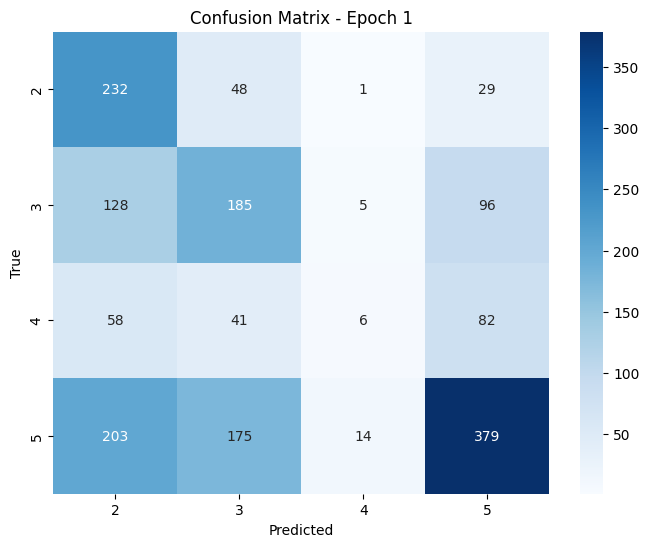

--------------------------------------------------------------------------------
Epoch 2/25
Train Loss: 1.2597, Train Acc: 0.4286, Train F1: 0.3591
Test Loss: 1.1288, Test Acc: 0.5654, Test F1: 0.4496
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[218  45   0  47]
 [ 72 236   0 106]
 [ 36  44   4 103]
 [102 173   3 493]]


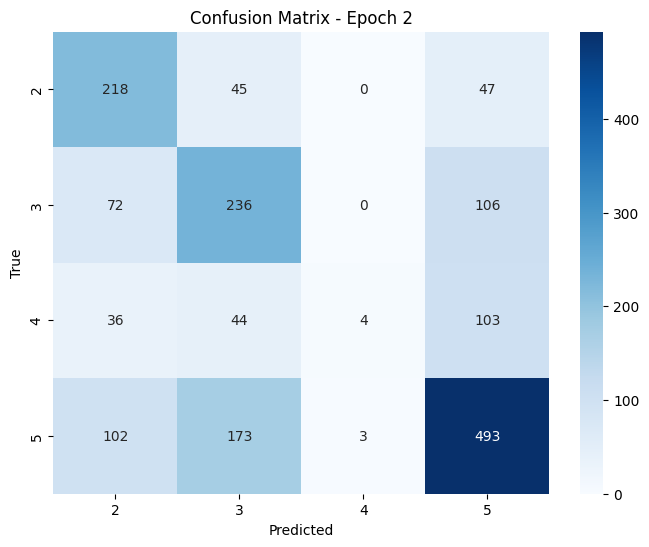

--------------------------------------------------------------------------------
Epoch 3/25
Train Loss: 1.1587, Train Acc: 0.4991, Train F1: 0.4035
Test Loss: 1.0788, Test Acc: 0.5969, Test F1: 0.4652
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[237  26   0  47]
 [ 84 209   0 121]
 [ 39  38   3 107]
 [110 104   2 555]]


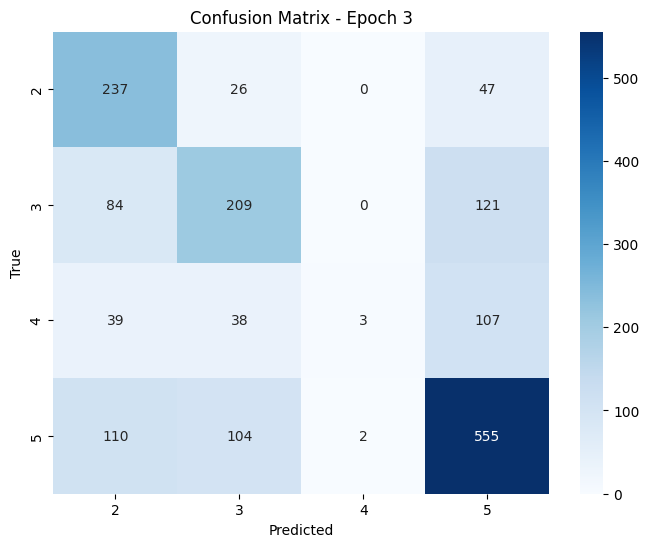

--------------------------------------------------------------------------------
Epoch 4/25
Train Loss: 1.0562, Train Acc: 0.5656, Train F1: 0.4575
Test Loss: 0.9830, Test Acc: 0.6326, Test F1: 0.5034
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[218  40   0  52]
 [ 43 259   0 112]
 [ 26  54   5 102]
 [ 58 131   0 582]]


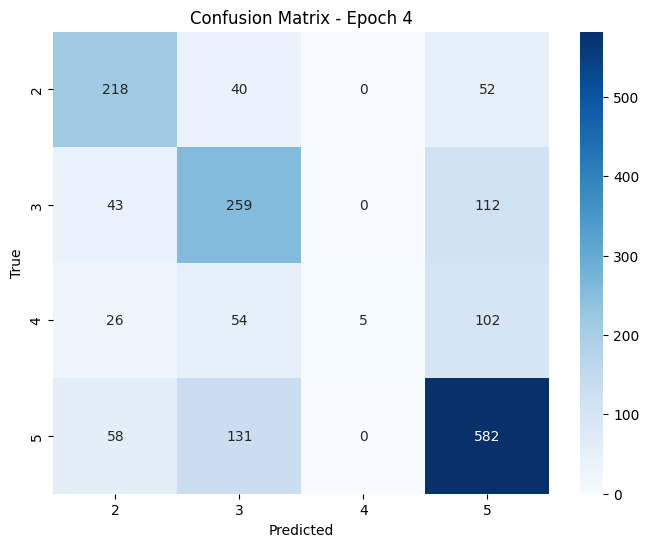

--------------------------------------------------------------------------------
Epoch 5/25
Train Loss: 0.9515, Train Acc: 0.6289, Train F1: 0.5129
Test Loss: 0.8885, Test Acc: 0.6748, Test F1: 0.5584
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[236  38   0  36]
 [ 44 274   0  96]
 [ 29  39  15 104]
 [ 52 107   2 610]]


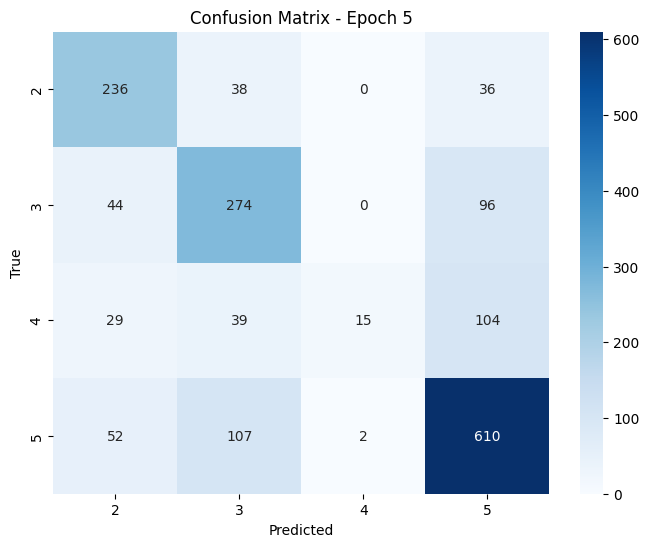

--------------------------------------------------------------------------------
Epoch 6/25
Train Loss: 0.8270, Train Acc: 0.6968, Train F1: 0.5673
Test Loss: 0.7824, Test Acc: 0.7111, Test F1: 0.5911
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[228  40   2  40]
 [ 36 299   1  78]
 [ 25  35  18 109]
 [ 42  76   2 651]]


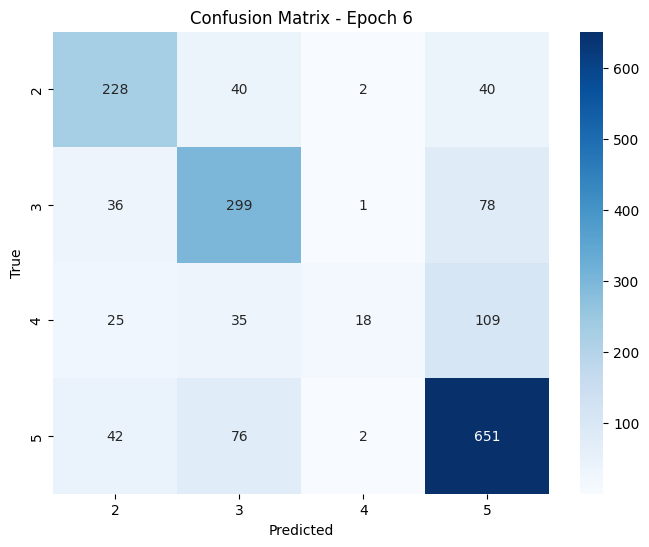

--------------------------------------------------------------------------------
Epoch 7/25
Train Loss: 0.6997, Train Acc: 0.7560, Train F1: 0.6327
Test Loss: 0.7176, Test Acc: 0.7515, Test F1: 0.6604
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[242  30   3  35]
 [ 26 347   2  39]
 [ 21  31  37  98]
 [ 42  84   7 638]]


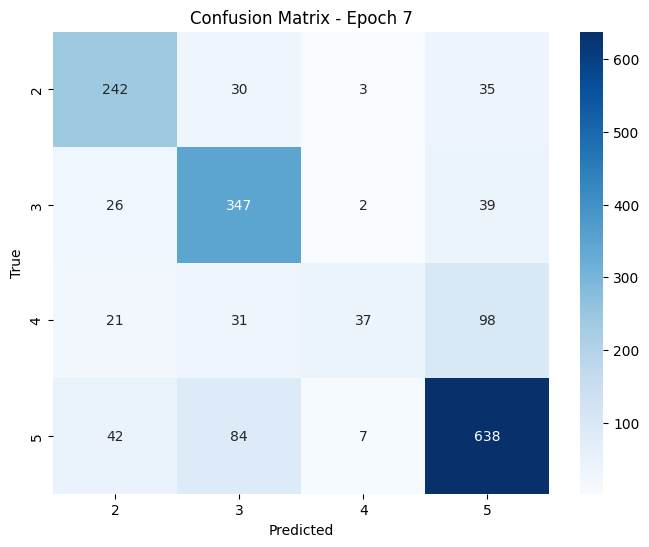

--------------------------------------------------------------------------------
Epoch 8/25
Train Loss: 0.6025, Train Acc: 0.8078, Train F1: 0.6971
Test Loss: 0.6305, Test Acc: 0.8109, Test F1: 0.7566
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[269  14   6  21]
 [ 24 337  13  40]
 [ 25  23  82  57]
 [ 30  49  16 676]]


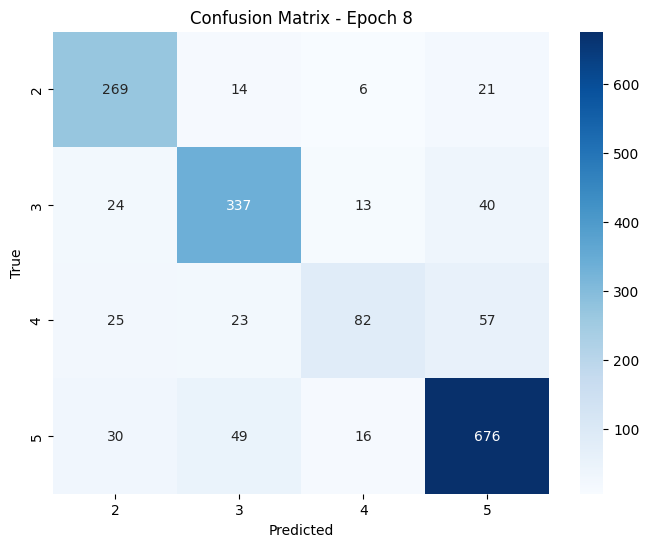

--------------------------------------------------------------------------------
Epoch 9/25
Train Loss: 0.5291, Train Acc: 0.8344, Train F1: 0.7513
Test Loss: 0.5181, Test Acc: 0.8377, Test F1: 0.7898
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[260  16   5  29]
 [ 12 357   7  38]
 [ 14  18  89  66]
 [ 21  33  14 703]]


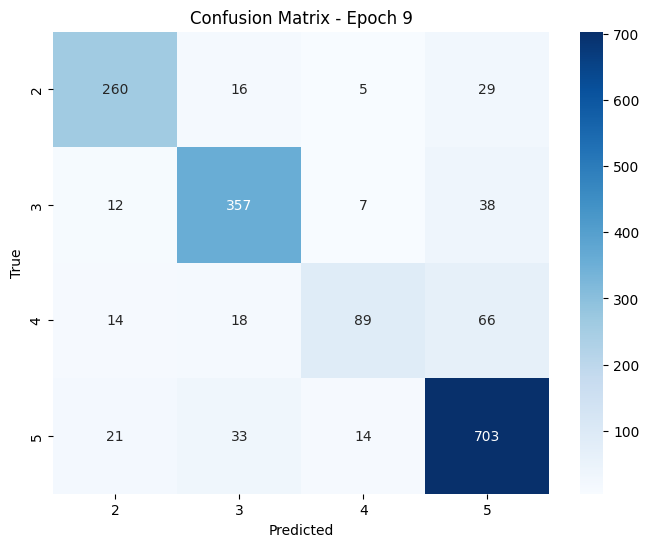

--------------------------------------------------------------------------------
Epoch 10/25
Train Loss: 0.4515, Train Acc: 0.8711, Train F1: 0.8110
Test Loss: 0.4998, Test Acc: 0.8573, Test F1: 0.8320
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[266  18  10  16]
 [ 13 357  16  28]
 [ 10  16 140  21]
 [ 16  42  34 679]]


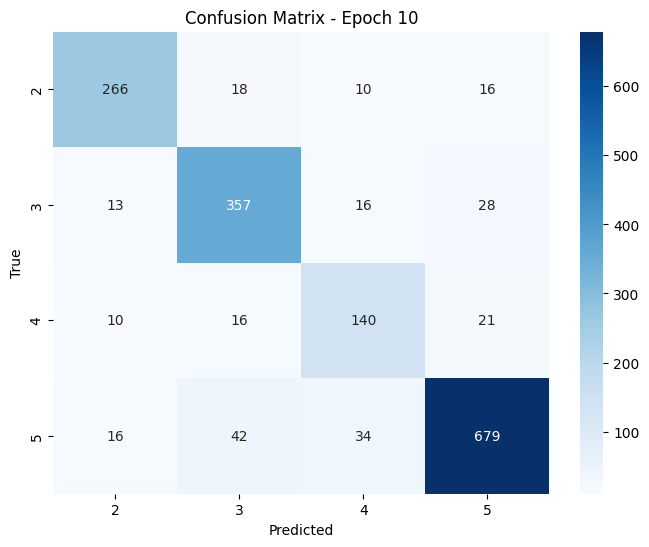

--------------------------------------------------------------------------------
Epoch 11/25
Train Loss: 0.3796, Train Acc: 0.8967, Train F1: 0.8563
Test Loss: 0.4299, Test Acc: 0.8751, Test F1: 0.8439
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[270   7  21  12]
 [ 13 356  12  33]
 [  8  16 133  30]
 [  8  25  25 713]]


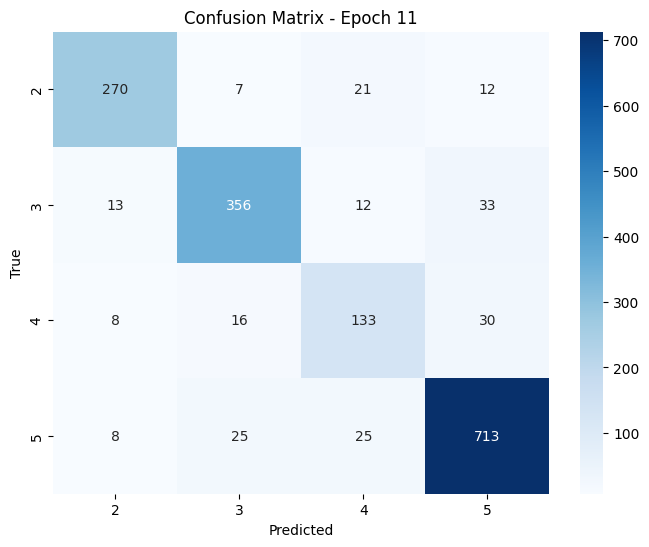

--------------------------------------------------------------------------------
Epoch 12/25
Train Loss: 0.3373, Train Acc: 0.9213, Train F1: 0.8988
Test Loss: 0.4330, Test Acc: 0.8650, Test F1: 0.8354
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[244  23  23  20]
 [  7 372  20  15]
 [  2  21 147  17]
 [  8  37  34 692]]


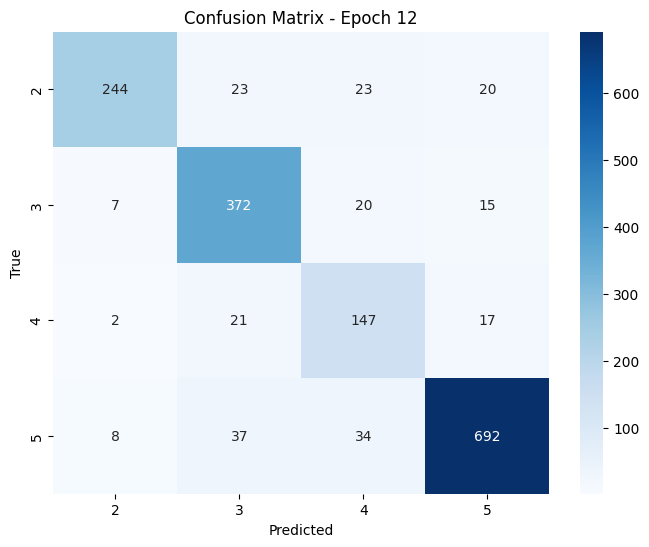

--------------------------------------------------------------------------------
Epoch 13/25
Train Loss: 0.2897, Train Acc: 0.9344, Train F1: 0.9172
Test Loss: 0.3457, Test Acc: 0.8894, Test F1: 0.8700
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[282  10   6  12]
 [ 11 352  19  32]
 [  4   9 152  22]
 [ 14  22  25 710]]


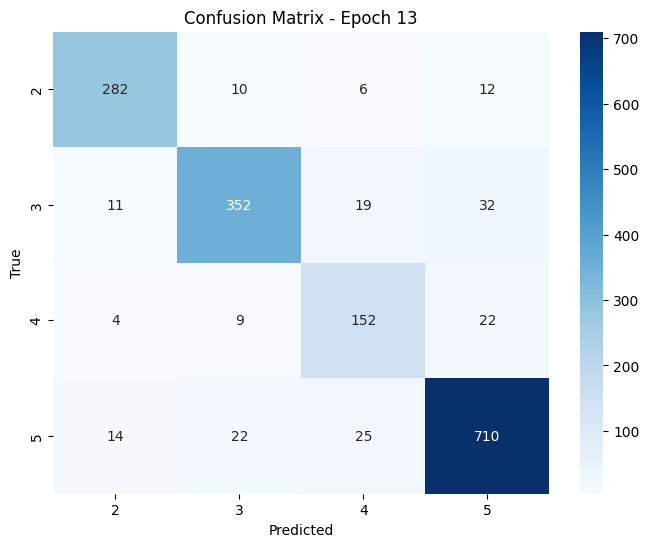

--------------------------------------------------------------------------------
Epoch 14/25
Train Loss: 0.2629, Train Acc: 0.9442, Train F1: 0.9309
Test Loss: 0.3396, Test Acc: 0.8918, Test F1: 0.8712
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[270   8   6  26]
 [ 11 346  18  39]
 [  3  13 148  23]
 [  6  14  15 736]]


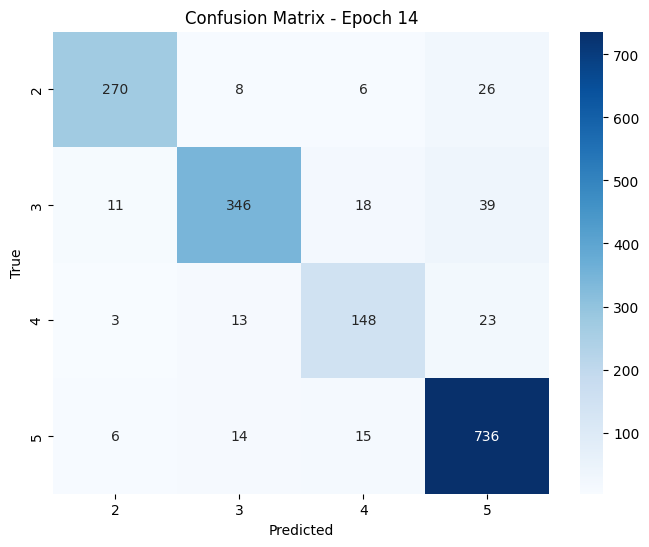

--------------------------------------------------------------------------------
Epoch 15/25
Train Loss: 0.2360, Train Acc: 0.9500, Train F1: 0.9384
Test Loss: 0.3090, Test Acc: 0.8977, Test F1: 0.8770
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[286   8   7   9]
 [ 14 355  17  28]
 [  6  10 149  22]
 [ 12  22  17 720]]


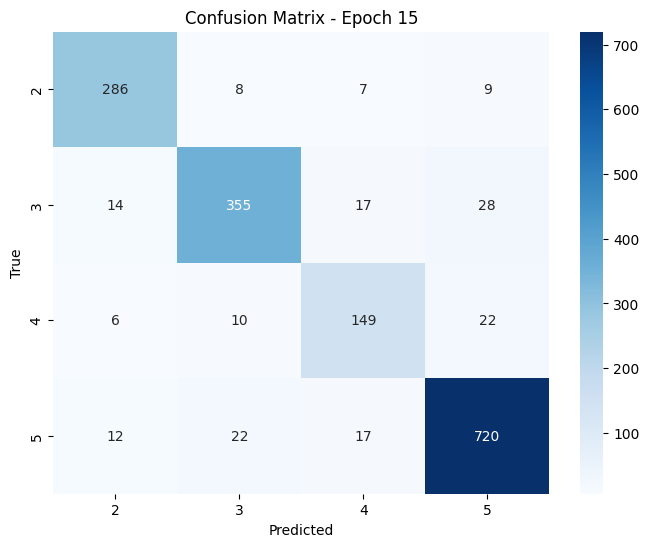

--------------------------------------------------------------------------------
Epoch 16/25
Train Loss: 0.2170, Train Acc: 0.9527, Train F1: 0.9414
Test Loss: 0.2965, Test Acc: 0.9055, Test F1: 0.8913
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[275  14   8  13]
 [  4 371  14  25]
 [  3  10 163  11]
 [  5  31  21 714]]


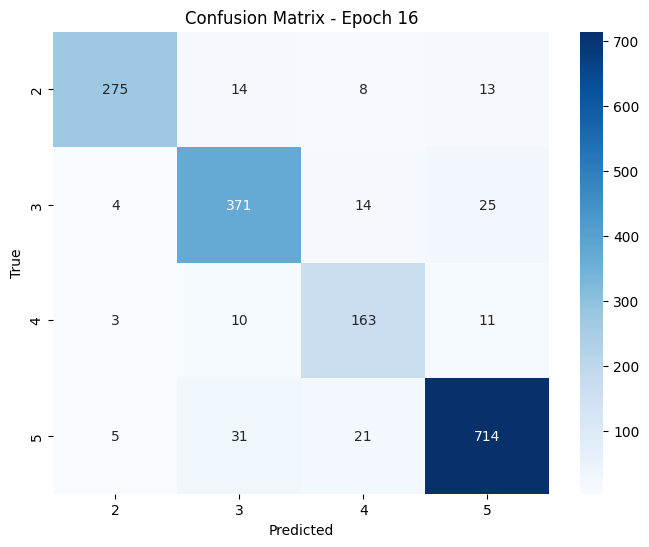

--------------------------------------------------------------------------------
Epoch 17/25
Train Loss: 0.1992, Train Acc: 0.9548, Train F1: 0.9462
Test Loss: 0.2974, Test Acc: 0.9043, Test F1: 0.8905
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[282   7   6  15]
 [  8 356  11  39]
 [  3   9 151  24]
 [  6  25   8 732]]


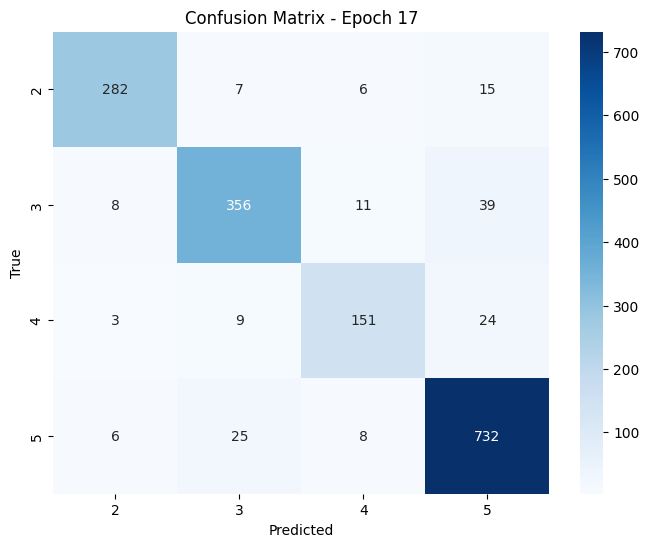

--------------------------------------------------------------------------------
Epoch 18/25
Train Loss: 0.1715, Train Acc: 0.9645, Train F1: 0.9589
Test Loss: 0.2724, Test Acc: 0.9061, Test F1: 0.8887
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[281   8   7  14]
 [  8 369  16  21]
 [  7  10 156  14]
 [ 11  27  15 718]]


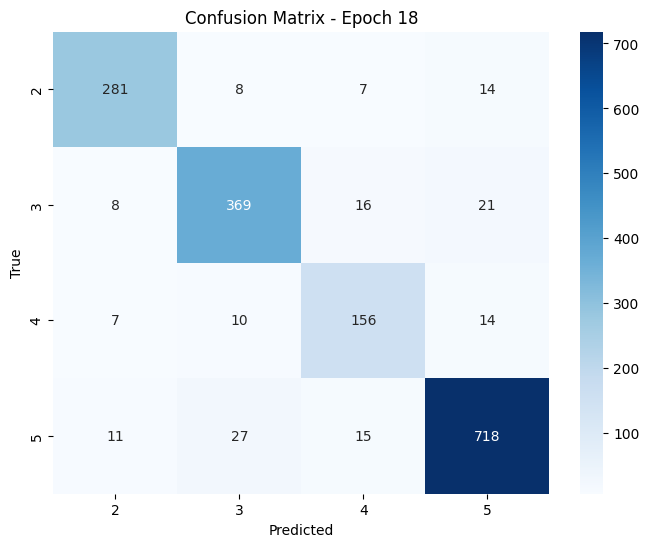

--------------------------------------------------------------------------------
Epoch 19/25
Train Loss: 0.1631, Train Acc: 0.9670, Train F1: 0.9635
Test Loss: 0.2613, Test Acc: 0.9180, Test F1: 0.9037
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[274   7   4  25]
 [  2 377   4  31]
 [  4   9 146  28]
 [  5  13   6 747]]


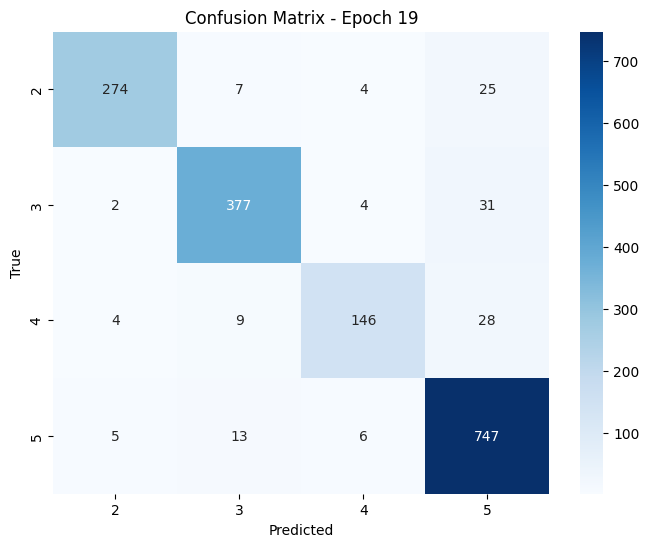

--------------------------------------------------------------------------------
Epoch 20/25
Train Loss: 0.1641, Train Acc: 0.9643, Train F1: 0.9595
Test Loss: 0.2539, Test Acc: 0.9120, Test F1: 0.8969
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[282   9  10   9]
 [  3 386   9  16]
 [  4   9 159  15]
 [ 12  31  21 707]]


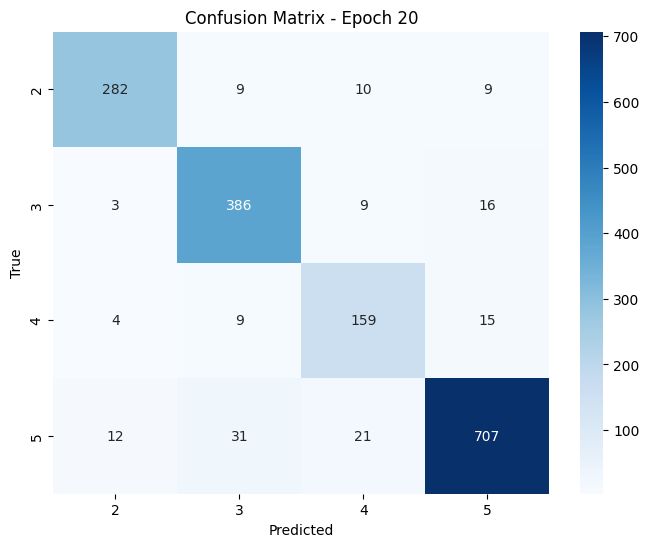

--------------------------------------------------------------------------------
Epoch 21/25
Train Loss: 0.1488, Train Acc: 0.9639, Train F1: 0.9584
Test Loss: 0.2539, Test Acc: 0.9132, Test F1: 0.8973
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[274   6   9  21]
 [  8 357  11  38]
 [  2   7 155  23]
 [  1  10  10 750]]


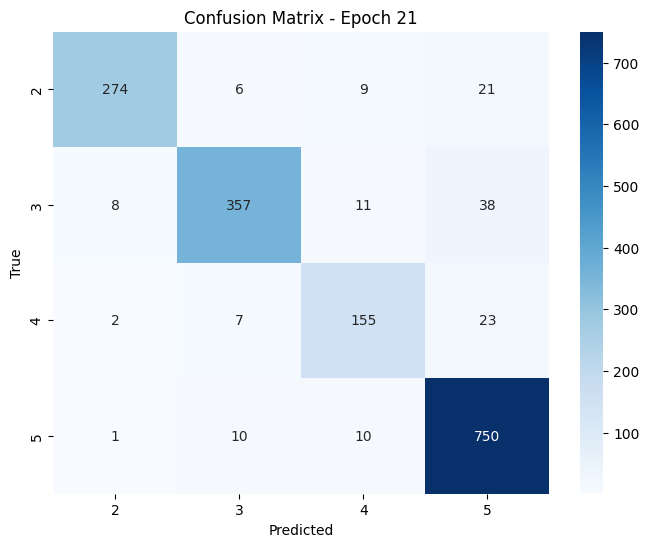

--------------------------------------------------------------------------------
Epoch 22/25
Train Loss: 0.1375, Train Acc: 0.9670, Train F1: 0.9622
Test Loss: 0.2513, Test Acc: 0.9168, Test F1: 0.9054
Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):
[[292   4   3  11]
 [ 14 363   7  30]
 [  5   8 160  14]
 [ 10  20  14 727]]


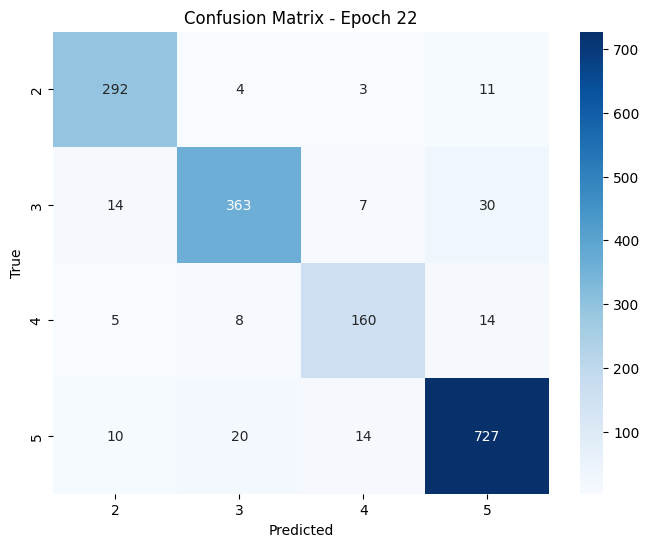

--------------------------------------------------------------------------------
Early stopping triggered after 22 epochs
Training completed. Best model saved to best_helpfulness_model.pth


In [14]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Định nghĩa đường dẫn
image_folder = 'processed_images'
mapping_file = 'processed_image_mapping.json'
data_file = 'images.json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Dùng GPU nếu có, nếu không thì CPU
print(f'Using device: {device}')

# Load file ánh xạ và dữ liệu
with open(mapping_file, 'r') as f:
    image_mapping = json.load(f)

with open(data_file, 'r') as f:
    data = json.load(f)

# Load PhoBERT
phobert = AutoModel.from_pretrained('vinai/phobert-base').to(device)
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
# Đóng băng toàn bộ tham số PhoBERT để tiết kiệm tài nguyên
for param in phobert.parameters():
    param.requires_grad = False
phobert.eval()

# Cache đặc trưng PhoBERT trong RAM (32GB đủ để lưu)
name_features_cache = {}
for item in data:
    product_name = item['product_name']
    if product_name not in name_features_cache:
        inputs = tokenizer(product_name, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.inference_mode():
            outputs = phobert(**inputs)
            name_feature = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            name_features_cache[product_name] = name_feature
print('PhoBERT features cached.')

# Load ResNet50
resnet = models.resnet50(pretrained=True).to(device)
# Chỉ fine-tune layer4 để giảm số tham số huấn luyện
for name, param in resnet.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Loại bỏ lớp fully connected
resnet.train()  # Bật chế độ huấn luyện cho layer4

# Transform cho ảnh với augmentation nhẹ để giảm overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.RandomRotation(5),       # Xoay nhẹ 5 độ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mã hóa product_category (0-4)
categories = [item['product_category'] for item in data]
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(np.array(categories).reshape(-1, 1))

# Dataset tùy chỉnh
class HelpfulnessDataset(Dataset):
    def __init__(self, data, image_mapping, image_folder, transform, encoder, name_features_cache):
        self.data = data
        self.image_mapping = image_mapping
        self.image_folder = image_folder
        self.transform = transform
        self.encoder = encoder
        self.name_features_cache = name_features_cache
        self.image_paths = []
        self.labels = []
        self.product_names = []
        self.categories = []

        # Lọc dữ liệu hợp lệ
        for item in data:
            id_str = str(item['id'])
            if id_str in image_mapping and isinstance(item.get('Image_helpfulness'), list) and len(item['Image_helpfulness']) > 0:
                if len(image_mapping[id_str]) > 0:
                    raw_label = item['Image_helpfulness'][0]
                    if 2 <= raw_label <= 5:
                        label = raw_label - 2  # Chuyển 2-5 thành 0-3
                        for img in image_mapping[id_str]:
                            self.image_paths.append(os.path.join(image_folder, img['image_file']))
                            self.labels.append(label)
                            self.product_names.append(item['product_name'])
                            self.categories.append(item['product_category'])
                    else:
                        print(f"Warning: Skipping sample {id_str} due to invalid helpfulness label: {raw_label}")
                else:
                    print(f"Warning: Skipping sample {id_str} because no images were successfully processed.")
            else:
                print(f"Warning: Skipping sample {id_str} due to missing image mapping or invalid helpfulness label.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        product_name = self.product_names[idx]
        category = self.categories[idx]

        # Load và biến đổi ảnh
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Lấy đặc trưng từ cache
        name_feature = self.name_features_cache[product_name]
        category_encoded = self.encoder.transform([[category]])[0]

        return img, name_feature, category_encoded, label

# Tạo dataset và dataloader với batch_size=16 để tận dụng 32GB RAM
dataset = HelpfulnessDataset(data, image_mapping, image_folder, transform, encoder, name_features_cache)
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6, pin_memory=torch.cuda.is_available())

# Định nghĩa mô hình với batch normalization và tăng dropout
class HelpfulnessModel(nn.Module):
    def __init__(self, name_feature_dim=768, category_dim=5, image_feature_dim=2048):
        super(HelpfulnessModel, self).__init__()
        self.fc1 = nn.Linear(name_feature_dim + category_dim + image_feature_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Thêm batch norm để ổn định
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)  # Tăng dropout để giảm overfitting
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Thêm batch norm
        self.fc3 = nn.Linear(128, 4)  # 4 lớp (image_helpfulness 2-5)

    def forward(self, image_features, name_features, category_features):
        combined = torch.cat((image_features, name_features, category_features), dim=1)
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Khởi tạo mô hình
model = HelpfulnessModel().to(device)
criterion = nn.CrossEntropyLoss()
# Tối ưu với weight_decay cao hơn và learning rate thấp hơn
optimizer = optim.Adam(
    list(model.parameters()) + [p for p in resnet.parameters() if p.requires_grad],
    lr=2e-5, weight_decay=5e-4
)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Hàm huấn luyện với early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, patience=3):
    best_acc = 0.0
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        resnet.train()  # Đảm bảo layer4 ở chế độ huấn luyện
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        # Vòng lặp huấn luyện
        for images, name_features, category_features, labels in train_loader:
            images = images.to(device)
            name_features = torch.tensor(name_features, dtype=torch.float32).to(device)
            category_features = torch.tensor(category_features, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            optimizer.zero_grad()
            image_features = resnet(images).squeeze().to(device)
            outputs = model(image_features, name_features, category_features)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # Đánh giá
        model.eval()
        resnet.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_preds = []
        test_labels = []

        with torch.inference_mode():
            for images, name_features, category_features, labels in test_loader:
                images = images.to(device)
                name_features = torch.tensor(name_features, dtype=torch.float32).to(device)
                category_features = torch.tensor(category_features, dtype=torch.float32).to(device)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

                image_features = resnet(images).squeeze().to(device)
                outputs = model(image_features, name_features, category_features)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_loss /= test_total
        test_acc = test_correct / test_total
        test_f1 = f1_score(test_labels, test_preds, average='macro')
        test_cm = confusion_matrix(test_labels, test_preds, labels=[0, 1, 2, 3])

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')
        print('Test Confusion Matrix (rows: true, cols: pred, labels 0-3 for helpfulness 2-5):')
        print(test_cm)

        # Vẽ ma trận nhầm lẫn
        plt.figure(figsize=(8, 6))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[2, 3, 4, 5], yticklabels=[2, 3, 4, 5])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.show()

        print('-' * 80)

        # Early stopping
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_helpfulness_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

        # Cập nhật scheduler
        scheduler.step(test_acc)

# Huấn luyện mô hình
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, patience=3)

print('Training completed. Best model saved to best_helpfulness_model.pth')

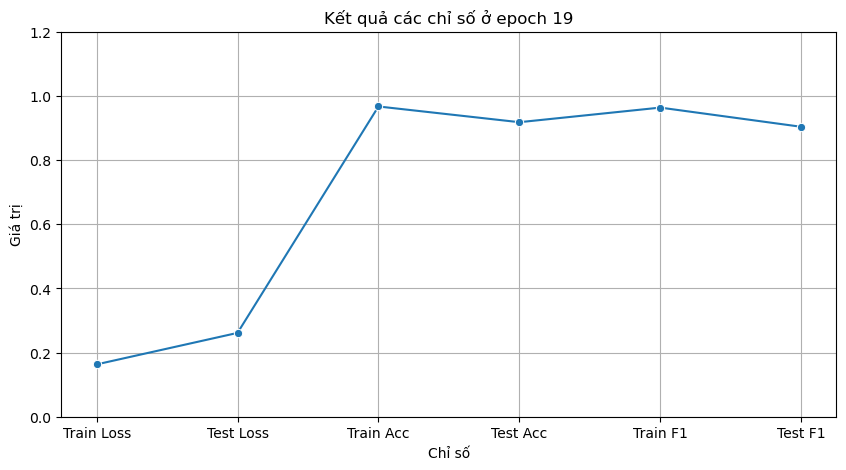

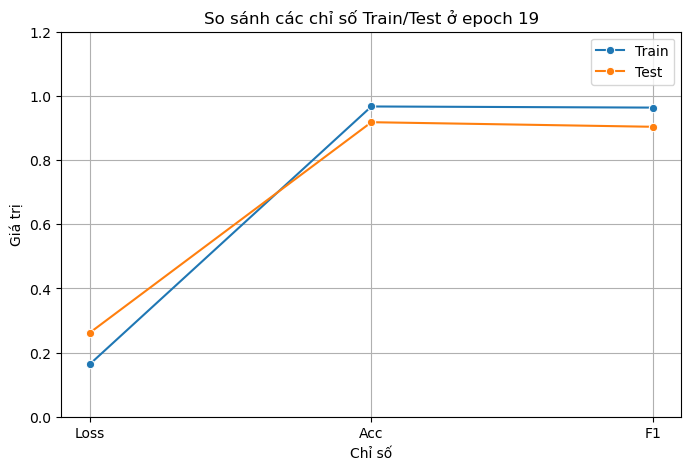

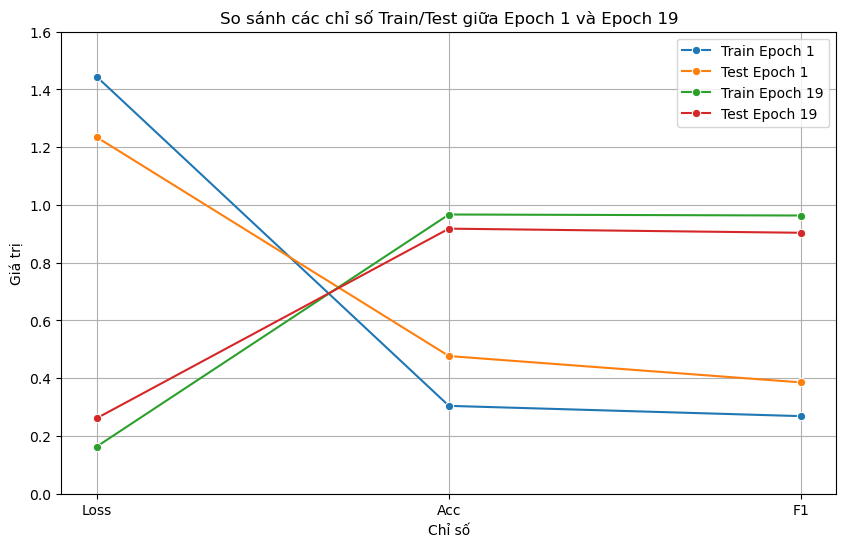

In [10]:
# Vẽ lineplot kết quả loss, accuracy, f1 của epoch 19
import matplotlib.pyplot as plt
import seaborn as sns

# Số liệu thực tế của epoch 19
epoch19_metrics = {
    'Train Loss': 0.1631,
    'Test Loss': 0.2613,
    'Train Acc': 0.9670,
    'Test Acc': 0.9180,
    'Train F1': 0.9635,
    'Test F1': 0.9037
}

metrics_names = list(epoch19_metrics.keys())
metrics_values = list(epoch19_metrics.values())

plt.figure(figsize=(10, 5))
sns.lineplot(x=metrics_names, y=metrics_values, marker='o')
plt.title('Kết quả các chỉ số ở epoch 19')
plt.ylabel('Giá trị')
plt.xlabel('Chỉ số')
plt.ylim(0, 1.2)
plt.grid(True)
plt.show()

# So sánh train và test bằng 2 đường lineplot
import matplotlib.pyplot as plt
import seaborn as sns

# Số liệu thực tế của epoch 19
train_values = [0.1631, 0.9670, 0.9635]  # Loss, Acc, F1
test_values = [0.2613, 0.9180, 0.9037]   # Loss, Acc, F1
metrics = ['Loss', 'Acc', 'F1']

plt.figure(figsize=(8, 5))
sns.lineplot(x=metrics, y=train_values, marker='o', label='Train')
sns.lineplot(x=metrics, y=test_values, marker='o', label='Test')
plt.title('So sánh các chỉ số Train/Test ở epoch 19')
plt.ylabel('Giá trị')
plt.xlabel('Chỉ số')
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend()
plt.show()

# So sánh train/test của epoch 1 và epoch 19 bằng lineplot
import matplotlib.pyplot as plt
import seaborn as sns

# Số liệu thực tế
metrics = ['Loss', 'Acc', 'F1']
train_epoch1 = [1.4445, 0.3043, 0.2687]
test_epoch1 = [1.2349, 0.4768, 0.3855]
train_epoch19 = [0.1631, 0.9670, 0.9635]
test_epoch19 = [0.2613, 0.9180, 0.9037]

plt.figure(figsize=(10, 6))
sns.lineplot(x=metrics, y=train_epoch1, marker='o', label='Train Epoch 1')
sns.lineplot(x=metrics, y=test_epoch1, marker='o', label='Test Epoch 1')
sns.lineplot(x=metrics, y=train_epoch19, marker='o', label='Train Epoch 19')
sns.lineplot(x=metrics, y=test_epoch19, marker='o', label='Test Epoch 19')
plt.title('So sánh các chỉ số Train/Test giữa Epoch 1 và Epoch 19')
plt.ylabel('Giá trị')
plt.xlabel('Chỉ số')
plt.ylim(0, 1.6)
plt.grid(True)
plt.legend()
plt.show()